# 0. Kodlayan ve Kodlanan hakkında bilgiler :)
#### Ad , Soyad , Numara , Şube : EREN KARA B211210031  1/B
#### Algoritma : Pix2PixGAN https://github.com/bnsreenu/python_for_microscopists/tree/master/251_satellite_image_to_maps_translation
#### DatasetOrnek : http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz
#### DatasetBen : https://www.kaggle.com/datasets/defileroff/comic-faces-paired-synthetic

# 1. Pix2Pix Nedir

Based on the code by Jason Brownlee from his blogs on https://machinelearningmastery.com/  
I seriously urge everyone to foloow his blogs and get enlightened.  
I am adapting his code to various applications but original credit goes to Jason.  

    Original paper: https://arxiv.org/pdf/1611.07004.pdf
    Github for original paper: https://phillipi.github.io/pix2pix/
    
    
### Generator'ı ve Discriminator'ı paper'da bizlere yapmamız gerektiği söylenen şekilde yapacağız.

Aşağıdaki Görünen C..'ler bizlerin layer olarak kullandığı convolutional layerlardaki filtreleri temsil ediyor.  
Makalede Generator bir U-Net'miş Discriminator ise PatchGAN.  
Peki PatchGAN ve U-NET nedir:
##### U-Net: Segmentasyon yapmaya yarayan bir yapı olarak düşünebiliriz.  Dahasına odevden sonra zaman bulduğumda bakacağım çok kapsamlı bir konu gibi duruyordu.
##### PatchGAN: Discriminator'da normalde bizler 1 tane real or fake diye sınıflandırma yapıyoruz ve ona göre işlemlerimize devam ediyoruz. Ancak PatchGan kendisine verilen bir Patch boyutu kadar bir bölgeyi real or fake diye sınıflandırıyor. Bütün resmi convolutional şekilde bu patch'den geçirdikten sonra ortaya daha düşük boyutlarda bir matris çıkıyor. Bu matris her bir patch'in real mi fake mi oldugunu içeren bir matris. En son ise bu matrisin artık ortalaması mı alınıyor ya da soft pooling mi yapılıyor her neyse sonuç olarak 1 tane real or fake uretiliyor.


Generator:    
The encoder-decoder architecture consists of:  
encoder:  
C64-C128-C256-C512-C512-C512-C512-C512  
decoder:   
CD512-CD512-CD512-C512-C256-C128-C64   


Discriminator  
C64-C128-C256-C512  
After the last layer, a convolution is applied to map to a 1-dimensional output, followed by a Sigmoid function. 
  
##### Makalede bir çok metric üzerinde durulmuş alpha rate'inden LeakyRelu'nun kullanılması ve hatta hangi derecede kullanılmasına kadar.
##### Ben de makaleye biraz baktım. Makalenin özetini yapan bir tane kanal buldum ve anladığım kadarıyla notlar üzerinde açıklayarak ilerleyeceğim

### Benim izleyerek ogrendiğim youtube kanalı
https://github.com/bnsreenu/python_for_microscopists/tree/master/251_satellite_image_to_maps_translation  
https://www.youtube.com/watch?v=UcHe0xiuvpg&list=PLZsOBAyNTZwboR4_xj-n3K6XBTweC4YVD&index=7  
https://youtu.be/UcHe0xiuvpg  
https://youtu.be/6pUSZgPJ3Yg  
https://youtu.be/my7LEgYTJto   

# ÖRNEK
Uydu görüntüsündenn map görüntüsüne image translation işlemi.   ​Pix2Pix GAN kullanılarak  
Data : http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz  
Başka dataset'leri için : http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/  

Kayknak kod kuş bakışı street view ile eşleşmiş olduğu map görüntüleri için hazırlanmıştı. Ben kendime uyarladım.  
Kaynak kodun bir çok yerinde değişiklik yaptığım için kendi örneğimi eğittiğim kaynak kod başka diğer dosya'da bulunuyor bu dosya hazır örnek için.  
Hazır kodu ve eğitilmiş olduğu datasetini bulabilsem ve okuyup inceleyip anlasam da eğitilmiş olan modeli bulamamıştım.  
Kendim bu yüzden bu datasetini 4 epoch kadar eğitime tabii tuttum.

# 2. Dependencies

In [1]:
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model
import tensorflow as tf
import os

# 3. Discriminator'un Tanımlanması

In [2]:
#Since pix2pix is a conditional GAN, it takes 2 inputs - image and corresponding label
#For pix2pix the label will be another image. 

# define the standalone discriminator model
#Given an input image, the Discriminator outputs the likelihood of the image being real.
    #Binary classification - true or false (1 or 0). So using sigmoid activation.
#Think of discriminator as a binary classifier that is classifying images as real/fake.

# From the paper C64-C128-C256-C512
#After the last layer, conv to 1-dimensional output, followed by a Sigmoid function.  

# Discriminator'ımız binary classification yapıyor yapmasına ancak bunu her bir patch için yapyıor. 
# En son ortaya koyduğu matrise iste

def define_discriminator(image_shape):
    
	# weight initialization
    # Burada RandomNormal makale'de kullanılması istenilen kernel initilaizer'mış. Tam olarak ne işe yaradığını anlamadım.
    # Okuma yaparsam güncellerim burayı
	init = RandomNormal(stddev=0.02) #As described in the original paper
    
	# source image input
    # Ornegin sokak fotoğraflarına (uydu görüntüsü) bakarak 
    # Map'lenmiş haritası çıkarılmış bir görüntü istiyoruz işte uydu görntüsü source image oluyor
	in_src_image = Input(shape=image_shape)  #Image we want to convert to another image
	# target image input
    # Target image ise uydu görüntüsünün map'lenmiş hali oluyor. 
	in_target_image = Input(shape=image_shape)  #Image we want to generate after training. 
    
	# concatenate images, channel-wise
    # ikisini channel olarak birbirine ekledik ornegin 32x32'lik bir elimizde image varsa bu image'in
    # 3 tane channel'dan (RGB) olustugunu dusunursek ekstra olarak diger image'ide concatenate ettigmizden toplamda
    # 6 tane channel'dan olusan 32x32'lik bir image elde ediyoruz gibi oluyor. Tek bir image gibi degil'de katman katman
    # arka arkaya dizilmiş matrisler gibi düşünebilirsin.
	merged = Concatenate()([in_src_image, in_target_image])
    
	# C64: 4x4 kernel Stride 2x2
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128: 4x4 kernel Stride 2x2
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256: 4x4 kernel Stride 2x2
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512: 4x4 kernel Stride 2x2 
    # Not in the original paper. Comment this block if you want.
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer : 4x4 kernel but Stride 1x1
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
    # Yine burada 1 tane layer kullanmamız gerektiğini makalede bizlere söylemiş.
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
    # Modele iki tane input vereceğiz ve 1 tane output alcağız diyoruz. 
	model = Model([in_src_image, in_target_image], patch_out)
	# compile model
    #The model is trained with a batch size of one image and Adam opt. 
    #with a small learning rate and 0.5 beta. 
    #The loss for the discriminator is weighted by 50% for each model update.
    
    # learning rate'i makale'de böyle belirlemiş.
    # Sanırım beta_1'i 0.999'da verebiliyoruz.
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

# 4. Encoder Blokları Tanımlamak

In [3]:
#Now define the generator - in our case we will define a U-net
# define an encoder block to be used in generator
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g

# 5. Decoder Blokları Tanımlamak

In [4]:
# define a decoder block to be used in generator
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g

# 6. Generator'ı Tanımlama

In [5]:
# define the standalone generator model - U-net
def define_generator(image_shape=(256,256,3)):
	# weight initialization
    # Burada RandomNormal makale'de kullanılması istenilen kernel initilaizer'mış. Tam olarak ne işe yaradığını anlamadım.
    # Okuma yaparsam güncellerim burayı.
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
    # U-NET'in mantığı ilk önce boyut küçültmek onda sonra'da boyut büyültmek. Aşağıdaki encoder ve decoderlar onu yapıyorlar.
	# encoder model: C64-C128-C256-C512-C512-C512-C512-C512
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
    # 512 tane 4x4'lük filtereye sahip convolutional layer 2'şer 2'şer horizantal ve vertical hareket edecekler.
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# decoder model: CD512-CD512-CD512-C512-C256-C128-C64
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output
    # Aşağıda son bir boyut arttıma yapılmış aşağıdaki ifade orjinal image'i iki katı boyutuna çıkarmaya yarıyor
    # Upsampling'den farklı bunu convolutional yol ile yapıyor olması.
	g = Conv2DTranspose(image_shape[2], (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7) #Modified 
    # Inputlar'ımızı scale etmeliyiz cunku output olarak tanh fonksiyonu kullandık.
	out_image = Activation('tanh')(g)  #Generates images in the range -1 to 1. So change inputs also to -1 to 1
	# define model
	model = Model(in_image, out_image)
	return model

# 7. Generator ve Discriminator'ı ortak bir neural networkde birbirinin ucuna eklemek

In [6]:
# BURADA YAPTIGIMIZ ŞEY: 
# Normalde Generator'ın çıktısını discrimiator'a vererek eğitme işlemini gerçekleştiriyoruz. 
# Bunu direkt olarak generator'ın network'ünü discriminator network'üne bağlayarak gerçekleştirebiliriz.
# Ancak burdaki dikkat edilmesi gereken husus generator'ı egitirken discriminator'ı eğitmemek.
# Bu yüzden trainable kısmını false yapıyoruz.
# Discriminator ve Generator birbirlerinden ayrı olarak eğitilecekler.
# KISACA : Asagida kurdumuz GAN yapısı bizlere Generator'ın ve Discriminator'ın birleşmiş bir halini veriyor. 

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False       #Descriminator layers set to untrainable in the combined GAN but 
                                                #standalone descriminator will be trainable.
            
	# define the source image
	in_src = Input(shape=image_shape)
	# suppy the image as input to the generator 
	gen_out = g_model(in_src)
	# supply the input image and generated image as inputs to the discriminator
    
    # discriminator input olarak iki şey bekliyor. Bir gerçek soruce image bir generator tarafından olusturulmus
    # pair edilmiş Map image.
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and disc. output as outputs
    # input olarak generator oldugundan source image'i vereceğiz ve sonucunda 
    # Burada output olarak generator'un olusturmus oldugu image'i de istiyoruz cunku MeanAverageError(MAE) Loss hesabı yapacağız.
    # Train ederken 1 tane sınıflandırması için real or fake label'i vereceğiz
    # Diğeri ise gerçek Map Görüntüsü olacak. Bu outputlardan birin real or fake ile loss'u alınacak diğerinin Map image ile.
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
    
    #Total loss is the weighted sum of adversarial loss (BCE) and L1 loss (MAE)
    #Authors suggested weighting BCE vs L1 as 1:100.
    
    # Burada MeanError'un rate'i 100 iken, binary crossentropy'nin 1
    # Binary crossentropy dicsriminator'ın tahmin ettiği değerden elde edilen loss. Yani eğerki discriminator fake derse
    # kendisini düzeltmesi için generato'ı optimize edicez.
    # MAE ise elimizdeki paired olan image'e (Harita Goruntusu) bakarak olusturduğumuz bir loss function oluyor.
	model.compile(loss=['binary_crossentropy', 'mae'], 
               optimizer=opt, loss_weights=[1,100])
	return model

# 8. Veri Kümesinden Veri Çekmek

In [7]:

# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# unpack dataset
	trainA, trainB = dataset
	# choose random instances
    # randint(baslangic,bitis,kacTane) 0 ile 4 arası 20 tane integer sayi.
	ix = randint(0, trainA.shape[0], n_samples)
	# retrieve selected images
    # Rastgele olarak batch size'ın yarısı ornek sayısı kadar veri çekmek.
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)
    # burada ones içerisine shape'ini veriyoruz. 4 boyut var.
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

# 9. Generator'a Fake Image'ler Yaptırmak

In [8]:
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

# 10. Training Fonksiyonu'nun Tanımlanması

In [9]:
# train pix2pix models
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
    # determine the output square shape of the discriminator
    n_patch = d_model.output_shape[1]
    # unpack dataset
    trainA, trainB = dataset
    # calculate the number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # manually enumerate epochs
    for i in range(n_steps):
        # select a batch of real samples
        [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
        # generate a batch of fake samples
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
        # update discriminator for real samples
        # X_realA -> Source (Satellite image)
        # X_realB -> Map (what we want to create)
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
        # update discriminator for generated samples
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
        # update the generator
        g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        # summarize performance
        print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
        # summarize model performance
        if (i+1) % (bat_per_epo * 10) == 0:
            summarize_performance(i, g_model, dataset)

# 11. GAN EGİTİMİ UZUN SURDUGUNDEN KAYDEDİP KONTROL ETME

In [10]:
# generate samples and save as a plot and save the model
#GAN models do not converge, we just want to find a good balance between
#the generator and the discriminator. Therefore, it makes sense to periodically
#save the generator model and check how good the generated image looks. 
def summarize_performance(step, g_model, dataset, n_samples=3):
	# select a sample of input images
	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	# generate a batch of fake samples
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	# scale all pixels from [-1,1] to [0,1]
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	# plot real source images
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + i)
		plt.axis('off')
		plt.imshow(X_realA[i])
	# plot generated target image
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples + i)
		plt.axis('off')
		plt.imshow(X_fakeB[i])
	# plot real target image
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples*2 + i)
		plt.axis('off')
		plt.imshow(X_realB[i])
	# save plot to file
	filename1 = 'plot_%06d.png' % (step+1)
	plt.savefig(filename1)
	plt.close()
	# save the generator model
	filename2 = 'model_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

# 12. VERİ KUMESİ İLE UGRASMA

In [11]:
from os import listdir
from numpy import asarray, load
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed
from matplotlib import pyplot
import numpy as np

# 13. Image'leri Yukleme

In [12]:
# load all images in a directory into memory
def load_images(path, size=(256,512)):
	src_list, tar_list = list(), list()
	# enumerate filenames in directory, assume all are images
	for filename in listdir(path):
		# load and resize the image
        # pixels = load_img(os.path.join(path,filename),target_size=size)
		pixels = load_img(path + filename, target_size=size)
		# convert to numpy array
		pixels = img_to_array(pixels)
		# split into satellite and map
		sat_img, map_img = pixels[:, :256], pixels[:, 256:]
		src_list.append(sat_img)
		tar_list.append(map_img)
	return [asarray(src_list), asarray(tar_list)]


# dataset path
path = 'maps/train/'
# load dataset
[src_images, tar_images] = load_images(path)
print('Loaded: ', src_images.shape, tar_images.shape)

Loaded:  (1096, 256, 256, 3) (1096, 256, 256, 3)


# 14. Yuklenen DataSetini Kontrol Etme

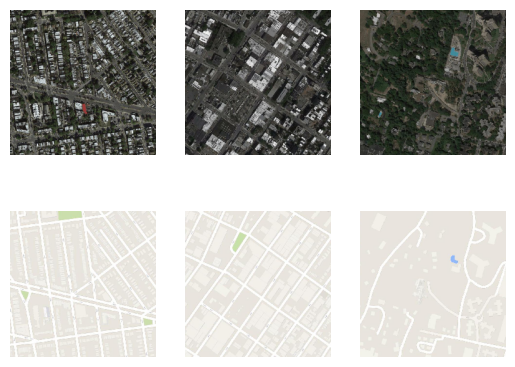

In [14]:
n_samples = 3
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(src_images[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(tar_images[i].astype('uint8'))
pyplot.savefig("Pix2PixModelTahminleri/Map/deneme3") 

       

pyplot.show()

# 15. Instance Olusturma

In [15]:
# define input shape based on the loaded dataset
image_shape = src_images.shape[1:] # 256x256x3
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)

C:\Users\Eren\anaconda3\Lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


# 16. Preprocess Data

In [16]:
#Define data
# load and prepare training images
data = [src_images, tar_images]

# GENEREATOR tanh fonksiyonu ile bir sonuc urettiginden ve onun araligi da -1 ile 1 arasında oldugundan
# asagidaki gibi -1 ile 1 arasında degisecek sekilde image'i preprocess'e tabi tuttuk

def preprocess_data(data):
	# load compressed arrays
	# unpack arrays
	X1, X2 = data[0], data[1]
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

dataset = preprocess_data(data)

# 17. TRAINING

In [35]:
from datetime import datetime 
start1 = datetime.now() 

train(d_model, g_model, gan_model, dataset, n_epochs=10, n_batch=1) 
#Reports parameters for each batch (total 1096) for each epoch.
#For 10 epochs we should see 10960

stop1 = datetime.now()
#Execution time of the model 
execution_time = stop1-start1
print("Execution time is: ", execution_time)

#Reports parameters for each batch (total 1096) for each epoch.
#For 10 epochs we should see 10960

1/1 [==============================] - 0s 160ms/step
>1, d1[0.393] d2[0.491] g[62.668]
1/1 [==============================] - 0s 156ms/step
>2, d1[0.376] d2[0.468] g[48.357]
1/1 [==============================] - 0s 155ms/step
>3, d1[0.379] d2[0.482] g[57.377]
1/1 [==============================] - 0s 167ms/step
>4, d1[0.384] d2[0.411] g[48.406]
1/1 [==============================] - 0s 178ms/step
>5, d1[0.380] d2[0.400] g[61.373]
1/1 [==============================] - 0s 169ms/step
>6, d1[0.334] d2[0.391] g[57.767]
1/1 [==============================] - 0s 170ms/step
>7, d1[0.115] d2[0.661] g[40.624]
1/1 [==============================] - 0s 173ms/step
>8, d1[0.446] d2[0.270] g[52.012]
1/1 [==============================] - 0s 170ms/step
>9, d1[0.458] d2[0.261] g[50.676]
1/1 [==============================] - 0s 160ms/step
>10, d1[0.535] d2[0.413] g[32.282]
1/1 [==============================] - 0s 175ms/step
>11, d1[0.261] d2[0.386] g[45.454]
1/1 [==============================] - 0s

KeyboardInterrupt: 

### Eger Istersen Onceden Egitilmis Bir Modeli Kullanabilirsin.

In [18]:
#Test trained model on a few images...

from keras.models import load_model
model = load_model('generator_epoch_14.h5')

# 18. Urettigimiz Sonuclari Goruntuleme Fonksiyonu

In [27]:
from numpy.random import randint

# plot source, generated and target images
def plot_images(src_img, gen_img, tar_img):
    images = vstack((src_img, gen_img, tar_img))
    # scale from [-1,1] to [0,1]
    images = (images + 1) / 2.0
    titles = ['Source', 'Generated', 'Expected']
    # plot images row by row
    for i in range(len(images)):
        # define subplot
        pyplot.subplot(1, 3, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(images[i])
        # show title
        pyplot.title(titles[i])
    pyplot.savefig("Pix2PixModelTahminleri/Map/denemeler5")        

    pyplot.show()

# 19. Urettigimiz Sonuclari Goruntuleme

(1, 256, 256, 3)
1/1 [==============================] - 0s 170ms/step


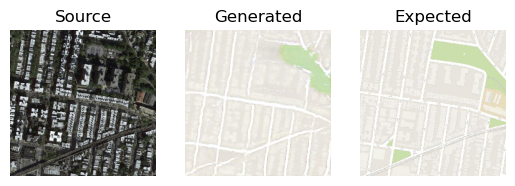

In [28]:
[X1, X2] = dataset
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]
print(src_image.shape)
# generate image from source
# gen_image = g_model.predict(src_image)
gen_image = model.predict(src_image)
# plot all three images
plot_images(src_image, gen_image, tar_image)